In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import time
import joblib
from statistics import median

import pandas_techinal_indicators
import pyfinancialdata
import trade_functions

from envs import SimpleTradingEnvironment
from agent import DQNAgent
from utils import get_scaler

# Auto reload
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Train and test data

Train on:
- GBP_USD
- USD_CAD
- AUD_USD

Test on: EUR_USD

In [2]:
train_data_1 = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
)

train_data_2 = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='USD_CAD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
)

train_data_3 = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='AUD_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
)

In [3]:
environment_columns = ['price', 'RSI_14', 'Momentum_7', 'ATR_7', 'ADX_7_14', 'TSI_5_10', 'KelChM_5', 'KelChU_5', 'KelChD_5']

def add_features(df):
    '''
    Adds feature columns to a pandas price data df
    '''
    df.reset_index(inplace=True)
    
    df = pandas_techinal_indicators.relative_strength_index(df, 14)
    df = pandas_techinal_indicators.momentum(df, 7)
    df = pandas_techinal_indicators.average_true_range(df, 7)
    df = pandas_techinal_indicators.average_directional_movement_index(df, 7, 14)
    df = pandas_techinal_indicators.true_strength_index(df, 5, 10)
    df = pandas_techinal_indicators.keltner_channel(df, 5)
    
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [4]:
train_data = [
    add_features(train_data_1),
    add_features(train_data_2),
    add_features(train_data_3),
]

In [5]:
train_data[0].head(5)

,date,close,high,low,open,price,RSI_14,Momentum_7,ATR_7,ADX_7_14,TSI_5_10,KelChM_5,KelChU_5,KelChD_5
0,2006-01-12 12:00:00,1.76080,1.77135,1.75800,1.76825,1.76080,0.494794,-0.00485,0.010280,0.317634,0.139388,1.763597,1.774227,1.752967
1,2006-01-13 00:00:00,1.76665,1.77165,1.75960,1.76080,1.76665,0.500048,0.00235,0.010723,0.307017,0.144453,1.763813,1.775363,1.752263
2,2006-01-13 12:00:00,1.77740,1.77845,1.76485,1.76665,1.77740,0.606954,0.00865,0.011444,0.302499,0.248947,1.766940,1.778760,1.755120
3,2006-01-15 12:00:00,1.77780,1.77900,1.77460,1.77460,1.77780,0.614644,0.01360,0.009680,0.283419,0.305419,1.769737,1.779927,1.759547
4,2006-01-16 00:00:00,1.76935,1.77970,1.76885,1.77780,1.76935,0.497277,0.01190,0.009973,0.299910,0.215166,1.770537,1.781387,1.759687


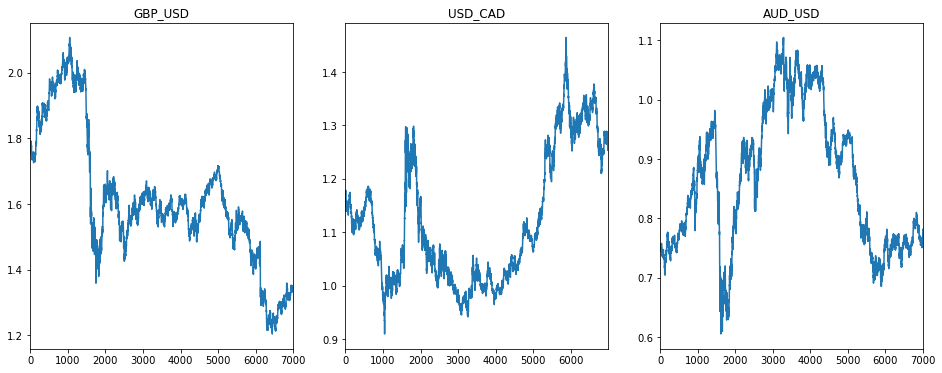

In [6]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(16,6))
axes[0].title.set_text('GBP_USD')
train_data[0]['price'].plot(ax=axes[0], subplots=True)
axes[1].title.set_text('USD_CAD')
train_data[1]['price'].plot(ax=axes[1], subplots=True)
axes[2].title.set_text('AUD_USD')
train_data[2]['price'].plot(ax=axes[2], subplots=True)
plt.show()

In [7]:
# train_size = round(len(price_data)/3*2)
# train_data = price_data[:train_size].copy()
# train_data.reset_index(drop=True, inplace=True)
# test_data = price_data[train_size:].copy()
# test_data.reset_index(drop=True, inplace=True)
# print('train size {0}, test size {1}'.format(len(train_data), len(test_data)))

In [8]:
print('train size {0}'.format(len(train_data[0]) + len(train_data[1]) + len(train_data[2])))

train size 20978


In [9]:
episode=1000
batch_size=10

## Train

In [10]:
# Environment columns + position state + unrealised account balance
state_size = len(environment_columns) + 1 + 1

# Sell, hold, buy
action_size = 3

# The agent
agent = DQNAgent(state_size, action_size)

# A df to save training performance while during training
train_results = pd.DataFrame()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                384       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
for d in train_data:
    env = SimpleTradingEnvironment(
        price_data=d,
        environment_columns=environment_columns,
        debug=False
    )
    
    scaler = get_scaler(env)
    
    print('=============')
    
    for e in range(episode):
        state = env.reset()
        state = scaler.transform([state])
        for i in range(env.n_step):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = scaler.transform([next_state])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                print(".", end='')
                if (e + 1) % 20 == 0:
                    print("")
                    print("episode: {0}/{1}".format(e + 1, episode))
                    print("median profit: {0} pips, median trade count: {1}".format(
                        round(median(train_results['account_balance'].tolist()) / 0.0001),
                        round(median(train_results['trade_count'].tolist()))
                        )
                    )
                train_results = train_results.append(env._stats(), ignore_index=True)
                break
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)



....................
episode: 20/1000
median profit: -139 pips, median trade count: 721
....................
episode: 40/1000
median profit: -362 pips, median trade count: 690
....................
episode: 60/1000
median profit: 78 pips, median trade count: 725
....................
episode: 80/1000
median profit: 789 pips, median trade count: 696
....................
episode: 100/1000
median profit: 929 pips, median trade count: 733
....................
episode: 120/1000
median profit: 1445 pips, median trade count: 735
....................
episode: 140/1000
median profit: 2202 pips, median trade count: 726
....................
episode: 160/1000
median profit: 2682 pips, median trade count: 725
....................
episode: 180/1000
median profit: 3112 pips, median trade count: 701
....................
episode: 200/1000
median profit: 3646 pips, median trade count: 690
....................
episode: 220/1000
median profit: 3834 pips, median trade count: 683
....................
episod

....................
episode: 780/1000
median profit: 3983 pips, median trade count: 548
....................
episode: 800/1000
median profit: 4002 pips, median trade count: 548
....................
episode: 820/1000
median profit: 4029 pips, median trade count: 547
....................
episode: 840/1000
median profit: 4065 pips, median trade count: 547
....................
episode: 860/1000
median profit: 4073 pips, median trade count: 546
....................
episode: 880/1000
median profit: 4073 pips, median trade count: 543
....................
episode: 900/1000
median profit: 4079 pips, median trade count: 542
....................
episode: 920/1000
median profit: 4115 pips, median trade count: 540
....................
episode: 940/1000
median profit: 4115 pips, median trade count: 540
....................
episode: 960/1000
median profit: 4123 pips, median trade count: 540
....................
episode: 980/1000
median profit: 4160 pips, median trade count: 539
....................


/usr/local/lib/python3.7/site-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.165625). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


..............
episode: 480/1000
median profit: 3470 pips, median trade count: 507
....................
episode: 500/1000
median profit: 3446 pips, median trade count: 505
....................
episode: 520/1000
median profit: 3430 pips, median trade count: 504
....................
episode: 540/1000
median profit: 3413 pips, median trade count: 504
....................
episode: 560/1000
median profit: 3395 pips, median trade count: 504
....................
episode: 580/1000
median profit: 3343 pips, median trade count: 505
....................
episode: 600/1000
median profit: 3296 pips, median trade count: 505
....................
episode: 620/1000
median profit: 3263 pips, median trade count: 505
....................
episode: 640/1000
median profit: 3223 pips, median trade count: 505
....................
episode: 660/1000
median profit: 3218 pips, median trade count: 507
....................
episode: 680/1000
median profit: 3216 pips, median trade count: 508
....................
episod

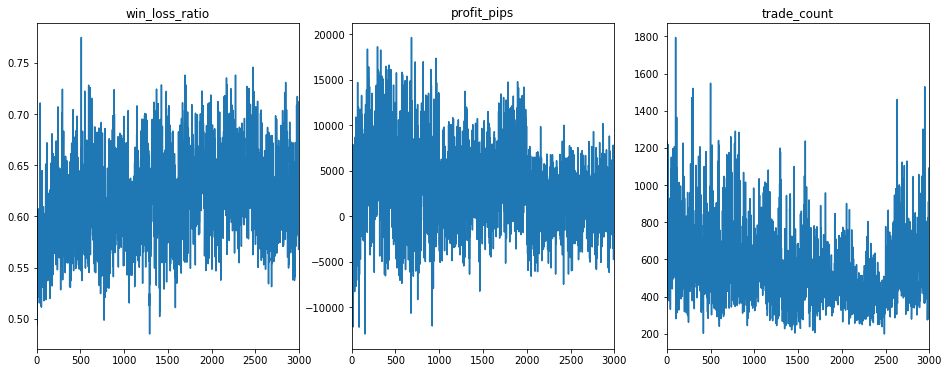

In [12]:
train_results['profit_pips'] = train_results['account_balance'] / 0.0001
columns_to_plot = ['win_loss_ratio', 'profit_pips', 'trade_count']
fig, axes = plt.subplots(nrows=1,ncols=len(columns_to_plot), figsize=(16,6))
for i in range(len(columns_to_plot)):
    axes[i].title.set_text(columns_to_plot[i])
    train_results[columns_to_plot[i]].plot(ax=axes[i], subplots=True)
plt.show()

In [13]:
joblib.dump(agent, 'trained-model.pkl') 

['trained-model.pkl']

## Test

In [14]:
# Uncomment to load agent from file 
# agent = joblib.load('trained-model.pkl')

In [15]:
test_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='EUR_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
)

test_data_with_features = add_features(test_data)

In [16]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data_with_features,
    environment_columns=environment_columns
)
state_size = env.observation_space.shape
action_size = env.action_space.n
scaler = get_scaler(env)
test_results = pd.DataFrame()

In [17]:
for e in range(500):
    state = env.reset()
    state = scaler.transform([state])
    for i in range(env.n_step):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        next_state = scaler.transform([next_state])
        state = next_state
        if done:
            test_results = test_results.append(env._stats(), ignore_index=True)
            break

In [18]:
test_results['account_balance_pips'] = test_results['account_balance'] / 0.0001
print('Median profit: {0} pips'.format(test_results['account_balance_pips'].median()))

Median profit: 2318.049999999957 pips


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ee92e90>]],
      dtype=object)

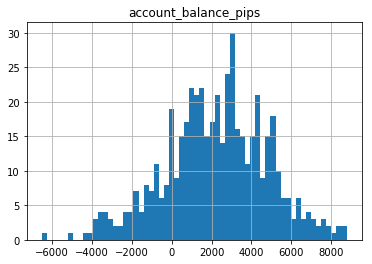

In [19]:
test_results.hist(column='account_balance_pips', bins=60)

In [21]:
# remake the env with test data
env = SimpleTradingEnvironment(
    price_data=test_data_with_features.copy(),
    environment_columns=environment_columns,
    save_positions_on_df=True
)
state_size = env.observation_space.shape
action_size = env.action_space.n

In [22]:
state = env.reset()
state = scaler.transform([state])
for i in range(env.n_step):
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    next_state = scaler.transform([next_state])
    state = next_state
    if done:
        break

In [23]:
env._stats()

{'trade_count': 629,
 'win_loss_ratio': 0.6565977742448331,
 'account_balance': 0.21017999999999382,
 'unrealised_pl': -0.010350000000000081}

In [24]:
position_data = env.price_data.copy()
position_data['position'] = position_data['position'] - 1
trades = trade_functions.create_trades_from_positions(position_data.copy())

631 positions to plot...


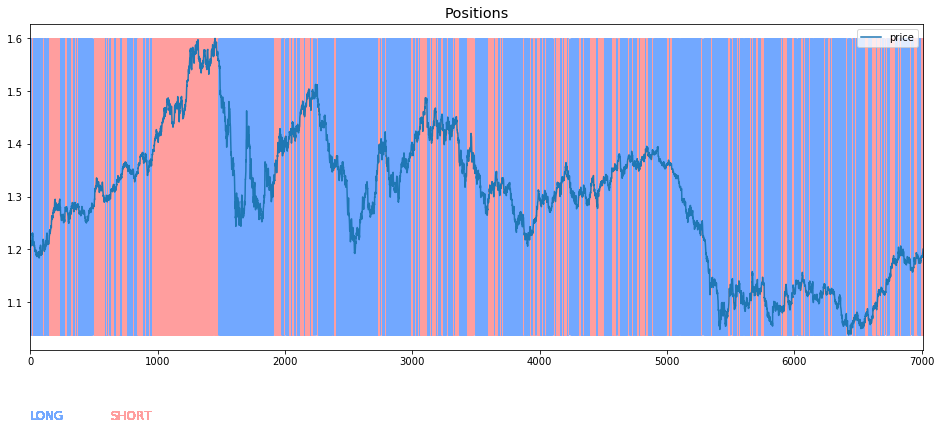

In [25]:
trade_functions.show_positions_on_price_plot(position_data.copy())

In [26]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 65.45%
Ratio of long to short positions: 1.4
Median profit: 0.0
Total profit: 0.19982999999999373
Median position length: 3.0
Number of trades: 631


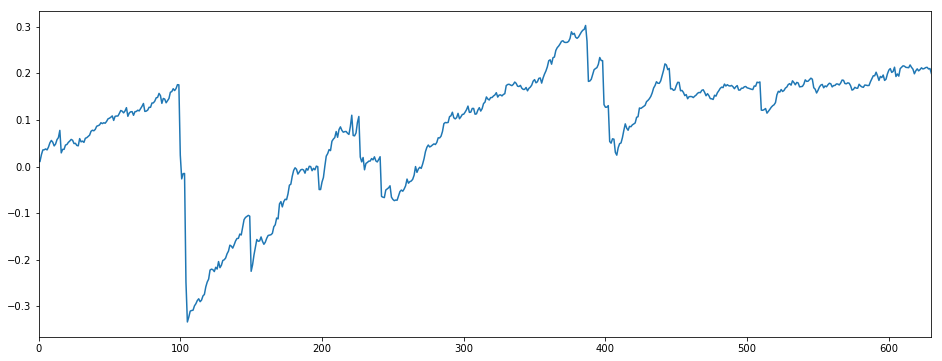

In [27]:
# Plot account balance
trades['account_balance'].plot(figsize=(16,6))

Median drawdown: -0.4050900000000025


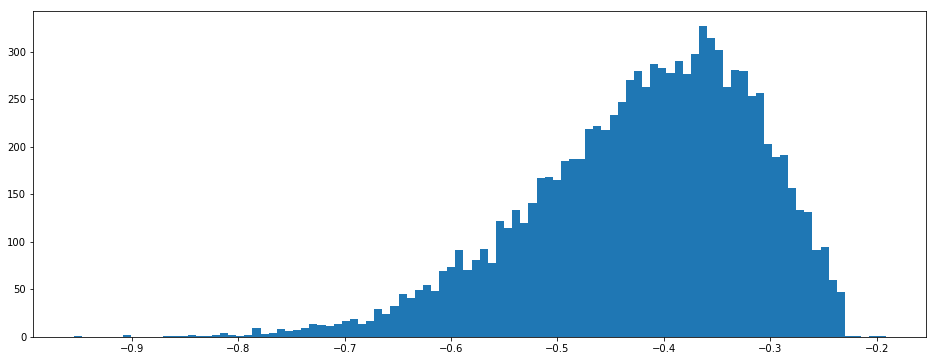

In [28]:
max_drawdown_results = trade_functions.plot_max_drawdown_distribution(trades.copy())
plt.figure(figsize=(16,6))
plt.hist(max_drawdown_results, bins=100);